## Ensemble Model Notebook

---

### Objective:

- Given the chosen sampling rate, extraction interval and selected filtered features, to investigate the potential benefit of an ensemble model.

### Methodology:

- Create 2 distinct models:
  - 1 to classify artifacts (label 0), normal (label 2) and abnormal (label 1) (murmur, extrahls, extrastoles)
  - 1 to classify murmur (label 4), extrahls (label 3) and extrastoles (label 5)
- Create a 3rd fusion model to give the final class

#### Findings:

Selected Features after the correlation analysis:


In [35]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score,balanced_accuracy_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

In [37]:
# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + 'raw/'

# Models
MODELS = "../../models/"
MODELS_RESULTS = MODELS + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 1

BALANCING_TYPE = "filtered"
RESULT_NAME = f"results_models_comparison_best_features_{BALANCING_TYPE}.csv"
CM_ARTIFACT_NAME = f"confusion_matrix_models_comparison_artifact_recognition_{BALANCING_TYPE}.npy"
CM_DISEASE_NAME = (
    f"confusion_matrix_models_comparison_disease_recognition_{BALANCING_TYPE}.npy"
)

In [38]:
# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "28mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "0cqt",
    "40 RMS": "0rms",
    "40 Zero Crossing Rates": "1zcr",
    "40 Spectral Centroid": "0sc",
    "60 Spectral Bandwidth": "0sb",
    "40 Spectral Rolloff": "0sr",
}

COMPLETE_DATA_PRIOR_CORR_NAME = f'full_data_{BALANCING_TYPE}_{INTERVAL}s_4000hz_' + '_'.join(numvalue for _, numvalue in num_feats.items()) + '.npy'
# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data['train']['X'].shape[1]

In [48]:
print("Class distribution")
print(pd.Series(full_data["train"]["y"]).value_counts())

Class distribution
3.0    1760
0.0     940
2.0     905
4.0     193
1.0     106
Name: count, dtype: int64


### 1st model - Classification of artifacts, normal and abnormal

In [39]:
# prepare the data
old_to_new_labels = {
     0: 0,
     1:1,
     2:1,
     3:2,
     4:1
}

# get the data
X_train = full_data['train']['X']
X_test = full_data['test']['X']

# replace the labels
y_train_newlabel = np.vectorize(old_to_new_labels.get)(full_data['train']['y'])
y_test_newlabel = np.vectorize(old_to_new_labels.get)(full_data['test']['y'])




Training Random Forest


	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training XGBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training MLP
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training CatBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy


,Test Acc,Macro F1,Balanced Accuracy
Random Forest,0.824795,0.824406,0.822011
XGBoost,0.836066,0.84179,0.837407
MLP,0.83709,0.846961,0.844714
CatBoost,0.860656,0.86729,0.862973


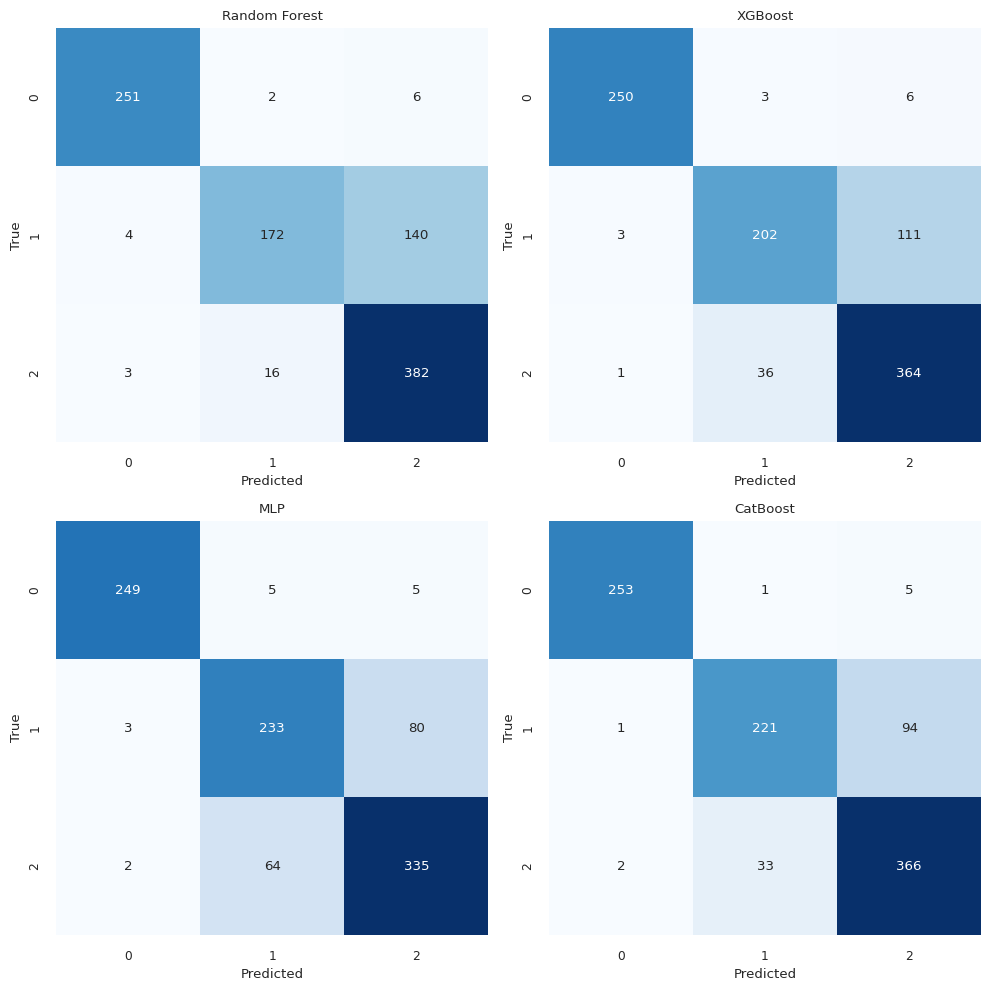

In [40]:
# ----------------------------------------- Create DataFrame to store results-----------------------------------------
MODELS = {'Random Forest': RandomForestClassifier(random_state=SEED),
        'XGBoost': XGBClassifier(random_state=SEED),
        'MLP': MLPClassifier(hidden_layer_sizes=(128, 64, 32,), activation='relu', solver='adam', random_state=SEED),
        'CatBoost': CatBoostClassifier(random_state=SEED, verbose=0),}

METRICS = {
    "Test Acc": accuracy_score,
    "Macro F1": f1_score,
    "Balanced Accuracy": balanced_accuracy_score,
}

result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}

# ----------------------------------------- Loop over each feature-----------------------------------------
for model_name, clf in MODELS.items():
    print(f"\nTraining {model_name}")


    # fit the model
    clf.fit(X_train, y_train_newlabel)
    
    for metric, funct in METRICS.items():
        print(f"\tCalculating {metric}")
        y_pred = clf.predict(X_test)

        if "Macro" in metric:
                result_df.loc[model_name, metric] = funct(y_test_newlabel, y_pred, average='macro')
        else:
                result_df.loc[model_name, metric] = funct(y_test_newlabel, y_pred)
        # cf
        cf = confusion_matrix(y_test_newlabel, y_pred)
        cm_dict[model_name] = cf

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
np.save(MODELS_RESULTS + CM_ARTIFACT_NAME, cm_dict)

# show the confusion matrix
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, (model_name, cf) in enumerate(cm_dict.items()):
    sns.heatmap(cf, annot=True, fmt='d', ax=ax[i//2, i%2], cmap='Blues', cbar=False)
    ax[i//2, i%2].set_title(model_name)
    ax[i//2, i%2].set_xlabel('Predicted')
    ax[i//2, i%2].set_ylabel('True')
plt.tight_layout()
result_df

In [41]:
best_3class_model = CatBoostClassifier(random_state=SEED, verbose=0)
best_3class_model.fit(X_train, y_train_newlabel)

## 2nd model - Heart disease prediction model (predicts the diseases only)

In [42]:
# prepare the data
old_to_new_labels = {
     1:0,
     2:1,
     4:2
}

# get the data
X_train = full_data['train']['X']
X_test = full_data['test']['X']
y_train = full_data['train']['y']
y_test = full_data['test']['y']

# remove class 0 and 3
train_mask = np.isin(y_train, [1, 2, 4])
test_mask = np.isin(y_test, [1, 2, 4])

X_train_disease = X_train[train_mask]
X_test_disease = X_test[test_mask]
y_train_disease = np.vectorize(old_to_new_labels.get)(y_train[train_mask])
y_test_disease = np.vectorize(old_to_new_labels.get)(y_test[test_mask])


Training Random Forest
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training XGBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training MLP
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy

Training CatBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy


,Test Acc,Macro F1,Balanced Accuracy
Random Forest,0.867089,0.764389,0.738009
XGBoost,0.882911,0.809417,0.790174
MLP,0.908228,0.86628,0.878668
CatBoost,0.905063,0.858911,0.848462


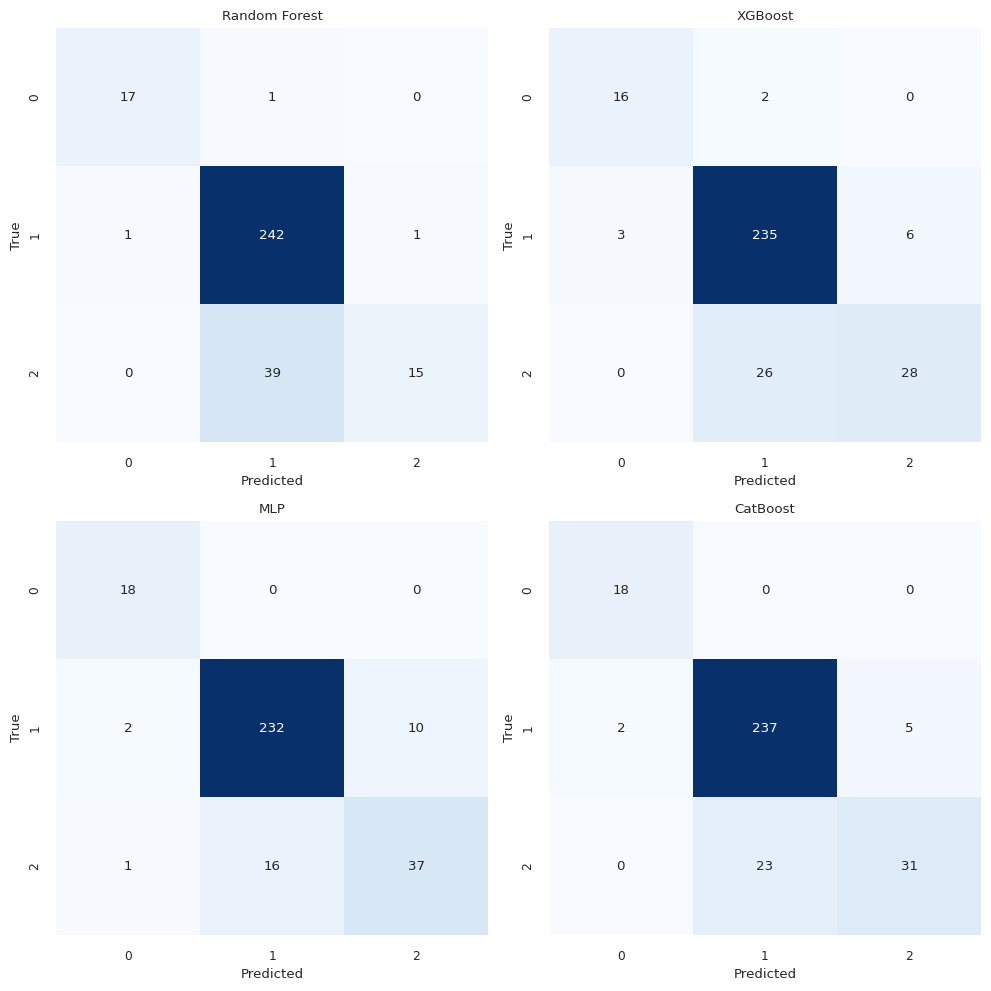

In [43]:
# df to store the results
result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}

# ----------------------------------------- Loop over each feature-----------------------------------------
for model_name, clf in MODELS.items():
    print(f"\nTraining {model_name}")

    # fit the model
    clf.fit(X_train_disease, y_train_disease)

    for metric, funct in METRICS.items():
        print(f"\tCalculating {metric}")
        y_pred = clf.predict(X_test_disease)

        if "Macro" in metric:
            result_df.loc[model_name, metric] = funct(y_test_disease, y_pred, average="macro")
        else:
            result_df.loc[model_name, metric] = funct(y_test_disease, y_pred)
        # cf
        cf = confusion_matrix(y_test_disease, y_pred)
        cm_dict[model_name] = cf

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
np.save(MODELS_RESULTS + CM_DISEASE_NAME, cm_dict)

# show the confusion matrix
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, (model_name, cf) in enumerate(cm_dict.items()):
    sns.heatmap(cf, annot=True, fmt='d', ax=ax[i//2, i%2], cmap='Blues', cbar=False)
    ax[i//2, i%2].set_title(model_name)
    ax[i//2, i%2].set_xlabel('Predicted')
    ax[i//2, i%2].set_ylabel('True')
plt.tight_layout()

result_df

In [44]:
best_disease_model = CatBoostClassifier(random_state=SEED, verbose=0)
best_disease_model.fit(X_train_disease, y_train_disease)

## SOluzione Semplice

In [45]:
def predict(class_model, disease_model, X):
    # Predict 3classes (0 for artifact, 1 for abnormal, 2 for normal)
    artifact_pred = class_model.predict(X).reshape(-1,)

    # Predict disease (assuming output is an integer class label 0, 1, 2 for diseases)
    disease_pred = disease_model.predict(X)

    # Ensure disease predictions are reshaped to match artifact predictions
    disease_pred = disease_pred.reshape(-1,)

    # Add 1 to disease predictions to differentiate disease classes from other classes
    y_pred = disease_pred + 3

    # Multiply by artifact predictions to set disease predictions to 0 for artifacts
    y_pred = y_pred * artifact_pred
    
    # reset labels to match the actual labels
    new_to_old_labels = {
        0: 0,
        3: 1,
        2: 3,
        4: 2,
        5: 4,
        6: 3,
        8: 3,
        10: 3,
    }
    y_pred = np.vectorize(new_to_old_labels.get)(y_pred)

    print(f"artifact_pred shape: {artifact_pred.shape}")
    print(f"disease_pred shape: {disease_pred.shape}")
    print(f"y_pred shape: {y_pred.shape}")

    return y_pred


# Extract data from the dictionary
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data["train"]["X"].shape[1]

# Extract data from the dictionary
X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]

y_pred = predict(best_3class_model, best_disease_model, X_test)

# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Accuracy Score: {accuracy}")
print(f"Balanced Accuracy Score: {balanced_accuracy}")

artifact_pred shape: (976,)
disease_pred shape: (976,)
y_pred shape: (976,)
F1 Score: 0.7333130138456145
Accuracy Score: 0.8463114754098361
Balanced Accuracy Score: 0.7246317477399608


## Uso un terzo modello per predire

F1 Score: 0.7333130138456145
Accuracy Score: 0.8463114754098361
Balanced Accuracy Score: 0.7246317477399608


Text(0.5, 1.0, 'Confusion Matrix')

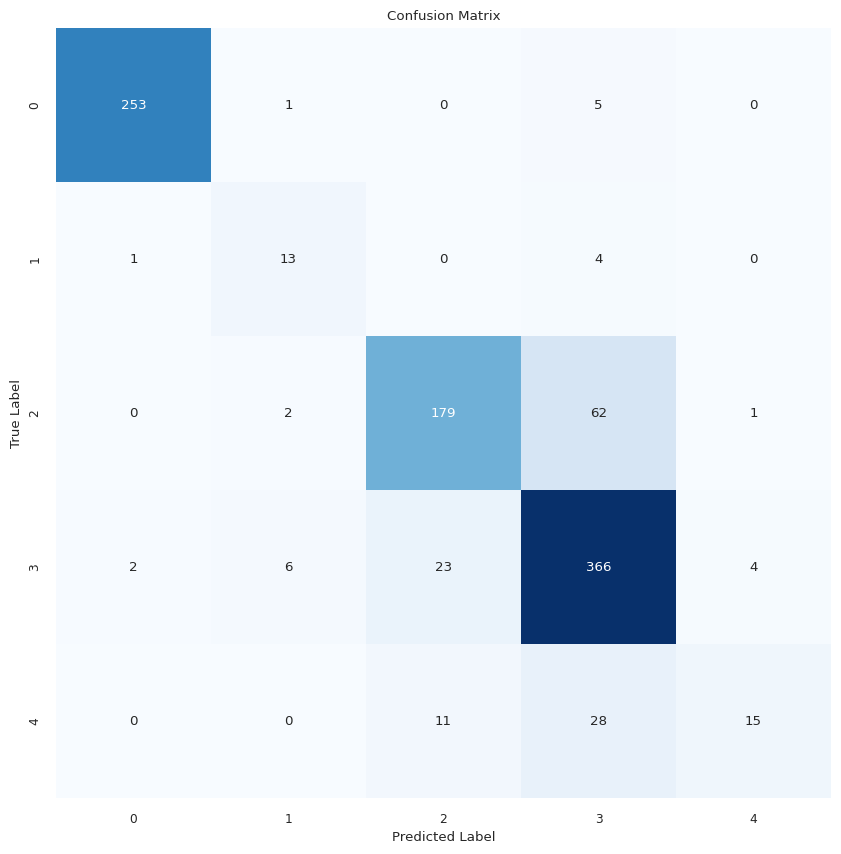

In [46]:
# Extract data from the dictionary
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data["train"]["X"].shape[1]

# Extract data from the dictionary
X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]


# Predictions for training data
pred_3class_train = best_3class_model.predict(X_train)
pred_disease_train = best_disease_model.predict(X_train)
pred_3class_test = best_3class_model.predict(X_test)
pred_disease_test = best_disease_model.predict(X_test)

# Concatenate predictions to form new feature set
X_train_new = np.concatenate(
    (pred_3class_train.reshape(-1, 1), pred_disease_train.reshape(-1, 1)), axis=1
)

X_test_new = np.concatenate(
    (pred_3class_test.reshape(-1, 1), pred_disease_test.reshape(-1, 1)), axis=1
)

# Train the final model
last_model = CatBoostClassifier(random_state=SEED, verbose=0)
last_model.fit(X_train_new, y_train)

# Predict using the final model
y_pred = last_model.predict(X_test_new)

# Calculate and print metrics
f1 = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Accuracy Score: {accuracy}")
print(f"Balanced Accuracy Score: {balanced_accuracy}")

# plot the confusion matrix
cf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")